# Part 2 - Application of Machine Learning on Time Series data Auser Data set   


The itent of this notebook is to explore the use of different machine learning models on a Time Series data set. The machine learning models include both univariate and a multivariate approach. 


# Methodology  

Data Cleannig and Preprocessing were preformed in Part 1 Notebook. 
This note book illustrates the following steps:

- **Model Selection** - Model selection is based on research across several sources supported by ChatGPT. (e.g. Kaggle, etc.)
- **Splitting the data for training and test sets** - This may vary between sets used for univariate and multivariate models and furthermore be adjusted to accomodate specific model requirements.
- **Model Build/Training** - Model build/training will vary based on the model type.
- **Model Evaluation** - Model evaluation will be done primarily using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE). With the results compared to the target value to 

# 1. Packages

In [1]:
# Base 
# -----------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Missing Value
# -----------------------------------
#!pip install missingno
import missingno as msno

# Configuration
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

from termcolor import colored

In [2]:
#'https://storage.googleapis.com/newagent-ahdsra.appspot.com/map.html'

In [3]:
#!pip install Prophet
#!pip install colorama

# 2. Loading Data

In [4]:
# Import
auser_ttset = pd.read_csv("auser_ttset.csv")
auser_ttset = auser_ttset.set_index('Date')
print("All files uploade successfully.")


All files uploade successfully.


In [5]:
# Check if the index is already in datetime format
if isinstance(auser_ttset.index, pd.DatetimeIndex):
    print("Index is already in datetime format.")
else:
    # Convert index to datetime
    auser_ttset.index = pd.to_datetime(auser_ttset.index)
    print("Index converted to datetime format.")

# Confirming index is datetime
if isinstance(auser_ttset.index, pd.DatetimeIndex):
    print("Index is in datetime format.")
else:
    raise ValueError("Index is not in datetime format after conversion. Please ensure it is in datetime format.")


Index converted to datetime format.
Index is in datetime format.


# 3. Model Selection


#  4. Splitting Data for the Train and Test Sets

Time series can be either univariate or multivariate:

* **Univariate** time series only has a single time-dependent variable.
* **Multivariate** time series have a multiple time-dependent variable.


In [6]:
#split the data frame 
try:
    # Step 1: Check if 'Depth_avg' and 'Date' index exist
    if 'Depth_avg' not in auser_ttset.columns or not isinstance(auser_ttset.index, pd.DatetimeIndex):
        raise ValueError("Required columns or datetime index missing.")
    
    # Step 2: Rename 'Depth_avg' to 'y'
    auser_ttset.rename(columns={'Depth_avg': 'y'}, inplace=True)
    auser_ttset.index.rename('ds', inplace=True)

    # Step 3: Split data
    split_point = int(len(auser_ttset) * 0.85)
    train_set = auser_ttset.iloc[:split_point]
    test_set = auser_ttset.iloc[split_point:]

    print("Data split into training and test sets.")

except Exception as e:
    print(f"An error occurred: {e}")

# Additional steps for LSTM preprocessing, such as normalization, can be added here if needed.


Data split into training and test sets.


In [7]:
from sklearn.preprocessing import MinMaxScaler

# Assuming 'auser_ttset' is already loaded, prepared, and the initial steps have been completed

try:
    # Step 4: Prepare data for ARIMA
    # ARIMA requires no specific format other than the time series itself, so we focus on the target variable 'y'
    arima_train = train_set['y']
    arima_test = test_set['y']

    print("Step 4: Data prepared for ARIMA model.")

    # Step 5: Prepare data for LSTM
    # Normalize the data for LSTM
    scaler = MinMaxScaler(feature_range=(0, 1))
    lstm_train_scaled = scaler.fit_transform(train_set[['y']])
    lstm_test_scaled = scaler.transform(test_set[['y']])

    # LSTM requires the data to be reshaped into [samples, time steps, features]
    # This is a simplified example assuming you're using a univariate series; adjust for multivariate
    def create_dataset(data, look_back=1):
        X, Y = [], []
        for i in range(len(data)-look_back-1):
            a = data[i:(i+look_back), 0]
            X.append(a)
            Y.append(data[i + look_back, 0])
        return np.array(X), np.array(Y)

    look_back = 1  # This can be adjusted based on the time step you want to consider
    X_train, y_train = create_dataset(lstm_train_scaled, look_back)
    X_test, y_test = create_dataset(lstm_test_scaled, look_back)

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    print("Step 5: Data prepared for LSTM model.")

    # Step 6: Prepare data for Prophet Univariate
    # Prophet expects a DataFrame with two columns: ds (Date) and y (target)
    prophet_train = train_set.reset_index()[['ds', 'y']]
    prophet_test = test_set.reset_index()[['ds', 'y']]

    print("Step 6: Data prepared for Prophet model.")

except Exception as e:
    print(f"An error occurred: {e}")

Step 4: Data prepared for ARIMA model.
Step 5: Data prepared for LSTM model.
Step 6: Data prepared for Prophet model.


# 5.1 Build/Train/Evaluate a Model using *Prophet* 

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from prophet import Prophet
from colorama import Fore

# Train the model
model = Prophet()
model.fit(prophet_train)

# Prepare a DataFrame with the dates from the test set
future_dates = prophet_test[['ds']]

# Use the model to make predictions
forecast = model.predict(future_dates)

# Merge the forecast with the actual values
evaluation_df = forecast[['ds', 'yhat']].merge(prophet_test, on='ds')

# Calculate MAE and RMSE
mae = round(mean_absolute_error(evaluation_df['y'], evaluation_df['yhat']), 5)
rmse = round(np.sqrt(mean_squared_error(evaluation_df['y'], evaluation_df['yhat'])), 5)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

11:32:30 - cmdstanpy - INFO - Chain [1] start processing
11:32:31 - cmdstanpy - INFO - Chain [1] done processing


MAE: 0.23284
RMSE: 0.31753


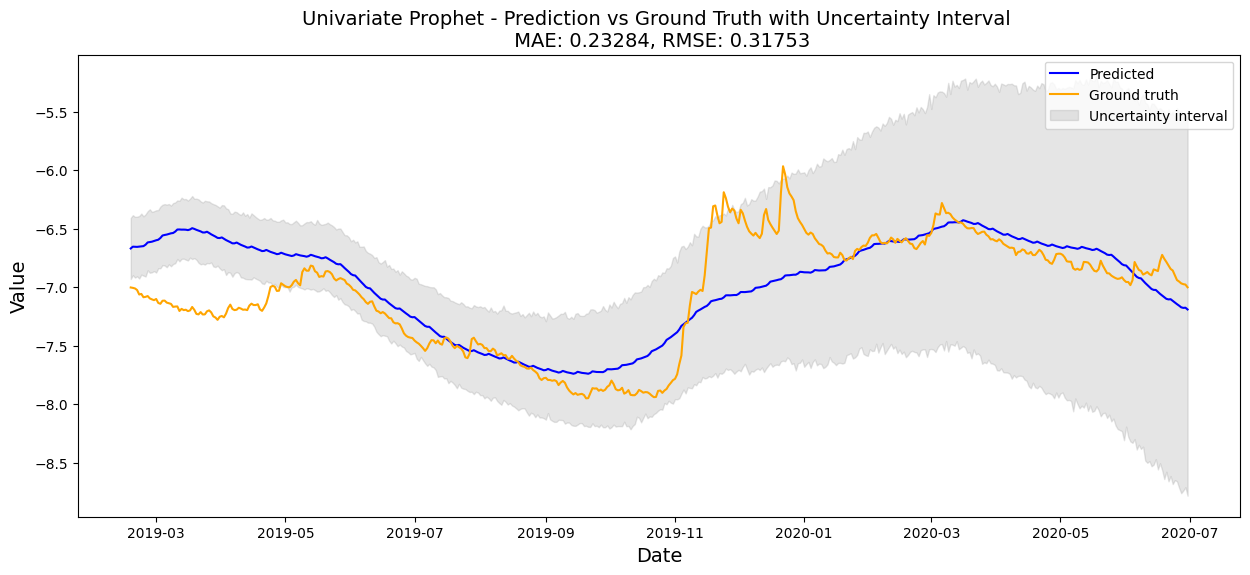

In [9]:
future_dates = prophet_test[['ds']] 

# Use the model to make predictions
forecast = model.predict(future_dates)

# Ensure forecast contains 'yhat', 'yhat_lower', and 'yhat_upper'
assert 'yhat_lower' in forecast.columns and 'yhat_upper' in forecast.columns, "Forecast does not contain lower and upper bounds"

# Merge the forecast with the actual values to evaluate, including the uncertainty intervals
evaluation_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(prophet_test[['ds', 'y']], on='ds')

# Plot the forecast alongside actual values and uncertainty interval
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

# Plot the predicted values
sns.lineplot(x=evaluation_df['ds'], y=evaluation_df['yhat'], ax=ax, label='Predicted', color='blue')

# Plot the actual values
sns.lineplot(x=evaluation_df['ds'], y=evaluation_df['y'], ax=ax, label='Ground truth', color='orange')

# Plot the uncertainty interval
plt.fill_between(evaluation_df['ds'], evaluation_df['yhat_lower'], evaluation_df['yhat_upper'], color='gray', alpha=0.2, label='Uncertainty interval')

ax.set_title(f'Univariate Prophet - Prediction vs Ground Truth with Uncertainty Interval \n MAE: {mae}, RMSE: {rmse}', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Value', fontsize=14)

plt.legend()
plt.show()


# 5.2 Build/Train/Evaluate a Model using *ARIMA* 

### Steps to build/analyze ARIMA

* **Step 1 — Filter out a validation sample**: This will be used to validate how accurate our model is. Use train test validation split to achieve this
* **Step 2 — Select AR and MA terms**: Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.
* **Step 3 — Build the model**: Build the model and set the number of periods to forecast to N (depends on your needs).
* **Step 4 — Validate model**: Compare the predicted values to the actuals in the validation sample.

In [10]:
arima_train.shape

(2833,)

In [11]:
from statsmodels.tsa.arima.model import ARIMA
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error
from colorama import Fore

# Assuming arima_train and arima_test are already defined, with arima_train being the training dataset
# and arima_test being the test dataset.

# If arima_train is a DataFrame with a DateTimeIndex, ensure it has a daily frequency set.
if isinstance(arima_train.index, pd.DatetimeIndex) and not arima_train.index.freq:
    arima_train.index.freq = 'D'

# Fit ARIMA model
# Ensure arima_train is properly prepared, e.g., it is a Series or a DataFrame with only the target variable.
model = ARIMA(arima_train, order=(2,1,0), freq='D')  # Specifying the order and daily frequency
model_fit = model.fit()

# Generate predictions
# The forecast steps are adjusted to match the length of arima_test.
forecast_steps = len(arima_test)
y_pred = model_fit.forecast(steps=forecast_steps)

# Assuming arima_test contains the actual values for comparison.
# No need for slicing since we're forecasting for the exact length of arima_test.
y_valid_adjusted = arima_test  # Direct comparison with the forecast.

# Calculate the metrics
score_mae = round(mean_absolute_error(y_valid_adjusted, y_pred), 5)
score_rmse = round(math.sqrt(mean_squared_error(y_valid_adjusted, y_pred)), 5)

# Print the RMSE and MAE in green text using colorama for colored output.
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))
print(Fore.GREEN + 'MAE: {}'.format(score_mae))


RMSE: 0.47579
MAE: 0.39144


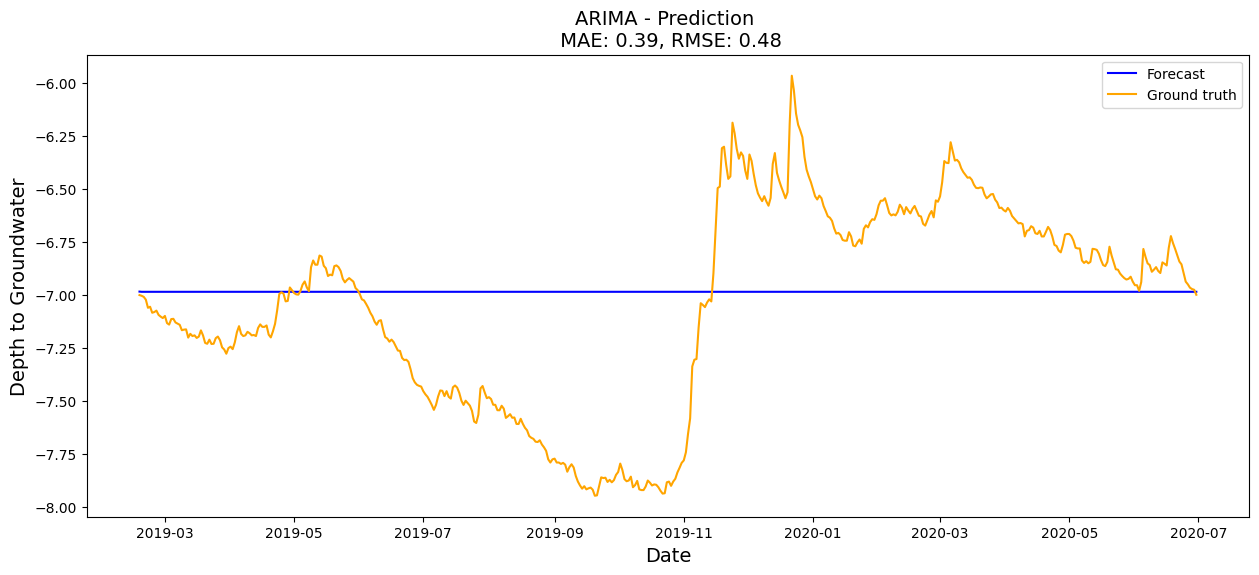

In [12]:
# Prepare the forecast DataFrame for plotting (assuming y_pred is already defined)
forecast_dates = arima_test.index  # Assuming the index of arima_test contains the datetime
forecast_df = pd.DataFrame({'ds': forecast_dates, 'yhat': y_pred})

# Plot the ARIMA forecast alongside the actual values
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

# Plotting the forecasted values
sns.lineplot(x='ds', y='yhat', data=forecast_df, ax=ax, label='Forecast', color='blue')

# Overlay the actual values
# Assuming arima_test is a Series with the datetime index and actual values
sns.lineplot(x=arima_test.index, y=arima_test, ax=ax, color='orange', label='Ground truth')

# Adjusting the plot with titles and labels
ax.set_title(f'ARIMA - Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Depth to Groundwater', fontsize=14)

plt.legend()
plt.show()

# 5.3 Build/Train/Evaluate a Model using *Auto-ARIMA* 


In [13]:
#pip install blosc2~=2.0.0

In [14]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(arima_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9066.631, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8859.097, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9064.559, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9063.239, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8861.024, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-9066.855, Time=0.78 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9067.471, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-9067.047, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-9065.253, Time=0.66 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-9069.423, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-9066.515, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-9068.996, Time=0.56 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-9068.803, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-9068.541, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0

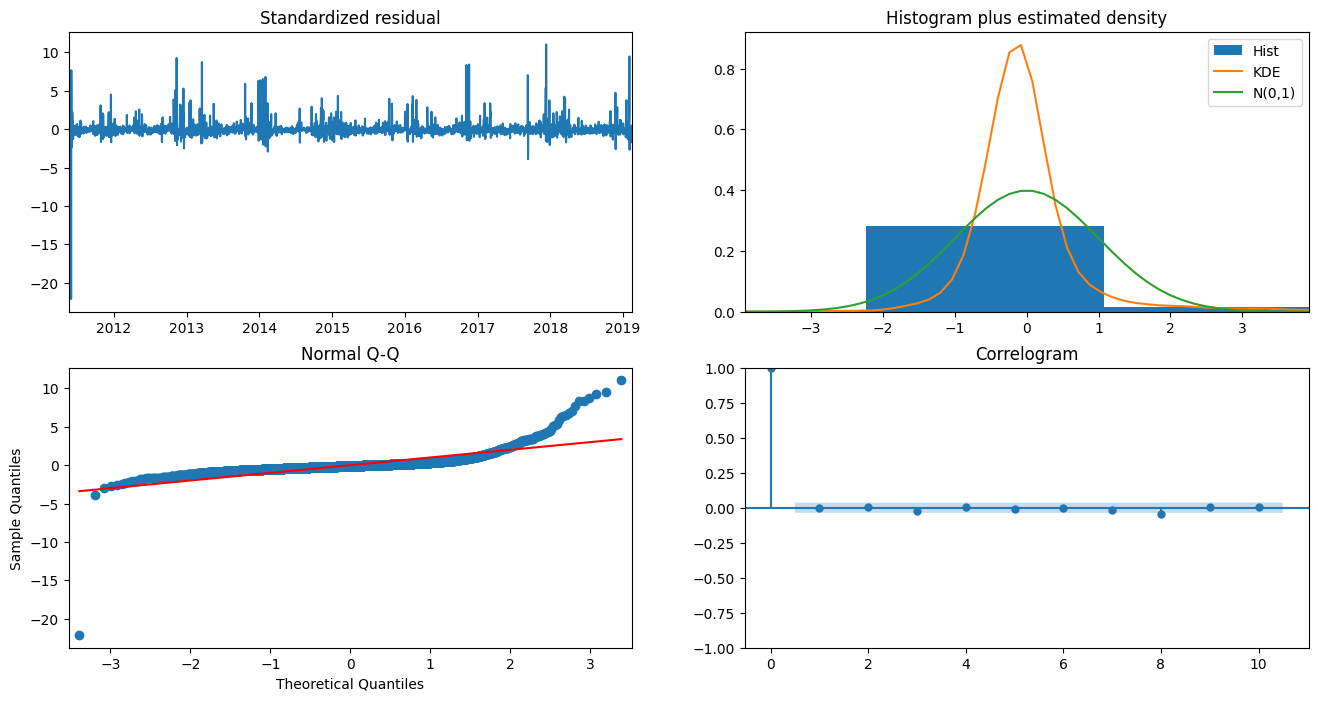

In [15]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

* **Top left**: The residual errors seem to fluctuate around a mean of zero but there is some non-uniform variance between (12.5, -5.0).

* **Top Right**: The density plot does not suggest normal distribution with mean zero.

* **Bottom left**: Not all the blue dots are over the red line, it seems that the distribution is a bit skewed.

* **Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated.

# 5.4 Build/Train/Evaluate a Model using *LSTM* 

The following data pre-processing and feature engineering need to be done before construct the LSTM model.
* Normalize the features.
* Convert an array of values into a dataset matrix.
* Reshape into X=t and Y=t+1.
* Reshape input to be 3D (num_samples, num_timesteps, num_features).

In [16]:
print(len(X_train), len(X_test))

2831 498


In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(X_train, y_train, batch_size=1, epochs=5, validation_data=(X_test, y_test))

model.summary()




Epoch 1/5

2831/2831 [==============================] - 9s 2ms/step - loss: 0.0022 - val_loss: 9.2397e-04
Epoch 2/5
2831/2831 [==============================] - 6s 2ms/step - loss: 6.9998e-04 - val_loss: 2.6162e-04
Epoch 3/5
2831/2831 [==============================] - 6s 2ms/step - loss: 6.6953e-04 - val_loss: 2.5482e-04
Epoch 4/5
2831/2831 [==============================] - 5s 2ms/step - loss: 6.3588e-04 - val_loss: 2.4738e-04
Epoch 5/5
2831/2831 [==============================] - 5s 2ms/step - loss: 5.8787e-04 - val_loss: 3.0146e-04
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)

In [18]:
# Lets predict with the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_mae = round(mean_absolute_error(y_test[0], test_predict[:,0]), 5)
score_rmse = round(np.sqrt(mean_squared_error(y_test[0], test_predict[:,0])), 5)
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))
print(Fore.GREEN + 'MAE: {}'.format(score_mae))

16/16 [==============================] - 0s 1ms/step
RMSE: 0.04789
MAE: 0.02807


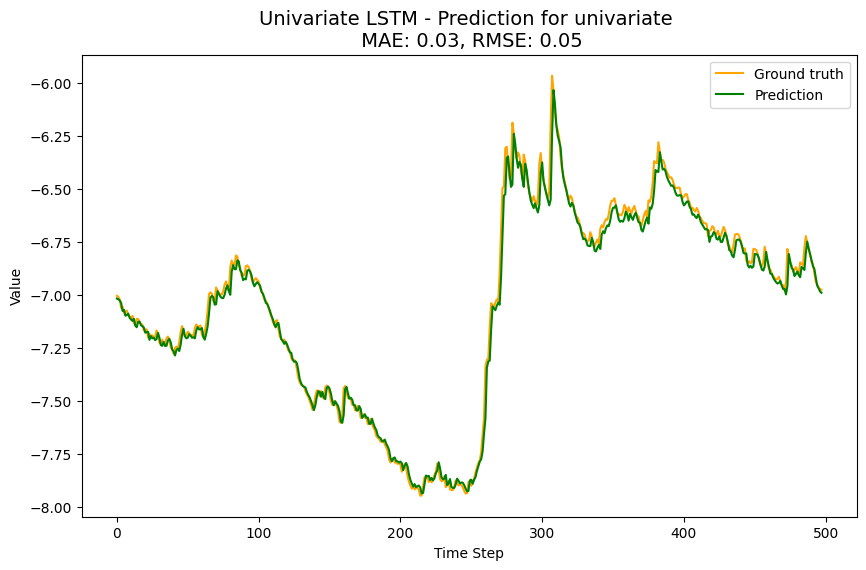

In [19]:
import matplotlib.pyplot as plt
# Plot testing data predictions
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(y_test[0], label='Ground truth', color='orange')
plt.plot(test_predict[:,0], label='Prediction', color='green')
plt.title(f'Univariate LSTM - Prediction for univariate \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

# Show plot
plt.show()

# 5.5 Build/Train/Evaluate Model a using *Multivariate Prophet* 


**Multivariate time series:** Multiple variables are varying over time. For example, a tri-axial accelerometer. There are three accelerations, one for each axis (x,y,z) and they vary simultaneously over time.

In [20]:
# Create the test sets for the multivariate model with two columns: ds (Date) and y (target)
mprophet_train = train_set.reset_index()[['ds', 'y', 'Rainfall_avg', 'Temperature_avg', 'Volume_tot_df1', 'Hydrometry_avg' ]]
mprophet_test = test_set.reset_index()[['ds', 'y', 'Rainfall_avg', 'Temperature_avg', 'Volume_tot_df1', 'Hydrometry_avg' ]]

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from colorama import Fore

# Initialize and configure the Prophet model
model = Prophet()

# Add additional regressors
feature_columns = [
    'Rainfall_avg',
    'Temperature_avg',
    'Volume_tot_df1',
    'Hydrometry_avg',
]

for feature in feature_columns:
    model.add_regressor(feature)

# Train the model using the mprophet_train DataFrame
# Ensure that mprophet_train includes 'ds', 'y', and the additional regressors
model.fit(mprophet_train)

# Prepare a DataFrame with the dates and regressors from the test set
# Ensure that mprophet_test includes 'ds' and the additional regressors
future_dates = mprophet_test[['ds'] + feature_columns]

# Use the model to make predictions
forecast = model.predict(future_dates)

# Merge the forecast with the actual values to evaluate
evaluation_df = forecast[['ds', 'yhat']].merge(mprophet_test[['ds', 'y']], on='ds')

# Calculate MAE and RMSE
mae = round(mean_absolute_error(evaluation_df['y'], evaluation_df['yhat']), 5)
rmse = round(math.sqrt(mean_squared_error(evaluation_df['y'], evaluation_df['yhat'])), 5)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

11:33:17 - cmdstanpy - INFO - Chain [1] start processing
11:33:18 - cmdstanpy - INFO - Chain [1] done processing


MAE: 0.22282
RMSE: 0.27182


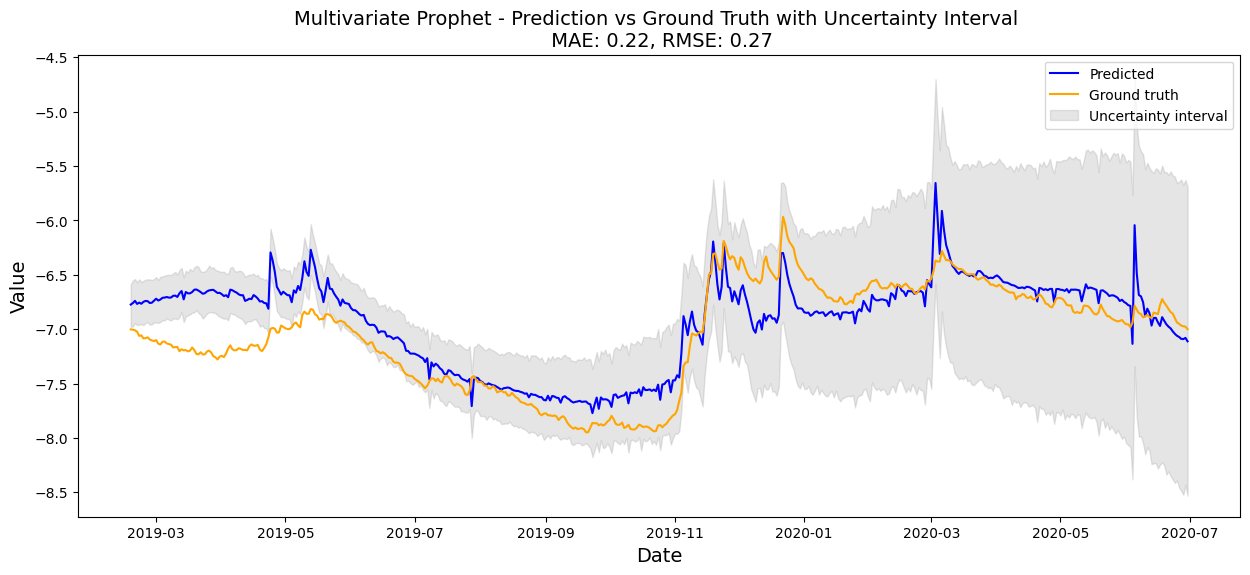

In [23]:
# Use the model to make predictions
forecast = model.predict(future_dates)

# Ensure forecast contains 'yhat', 'yhat_lower', and 'yhat_upper'
assert 'yhat_lower' in forecast.columns and 'yhat_upper' in forecast.columns, "Forecast does not contain lower and upper bounds"

# Merge the forecast with the actual values to evaluate, including the uncertainty intervals
evaluation_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(mprophet_test[['ds', 'y']], on='ds')

# Plot the forecast alongside actual values and uncertainty interval
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

# Plot the predicted values
sns.lineplot(x=evaluation_df['ds'], y=evaluation_df['yhat'], ax=ax, label='Predicted', color='blue')

# Plot the actual values
sns.lineplot(x=evaluation_df['ds'], y=evaluation_df['y'], ax=ax, label='Ground truth', color='orange')

# Plot the uncertainty interval
plt.fill_between(evaluation_df['ds'], evaluation_df['yhat_lower'], evaluation_df['yhat_upper'], color='gray', alpha=0.2, label='Uncertainty interval')

ax.set_title(f'Multivariate Prophet - Prediction vs Ground Truth with Uncertainty Interval \n MAE: {mae:.2f}, RMSE: {rmse:.2f}', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Value', fontsize=14)

plt.legend()
plt.show()

# 5.6 Build/Train/Evaluate a Model using *XGBoost Regressor* 


**Multivariate time series:** Multiple variables are varying over time. For example, a tri-axial accelerometer. There are three accelerations, one for each axis (x,y,z) and they vary simultaneously over time.

In [24]:
#pip install xgboost

In [25]:
from xgboost import XGBRegressor
import xgboost as xgb

#The train and test sets are partially created from Multivariate Prophet

In [26]:
import pandas as pd

def create_features(df):
    """
    Create time series features based on the 'ds' column of the DataFrame.
    
    Parameters:
    - df: DataFrame containing the 'ds' column.
    
    Returns:
    - A new DataFrame with new time series features appended and the 'ds' column dropped.
    """
    
    # Ensure 'ds' is a datetime column
    if not pd.api.types.is_datetime64_any_dtype(df['ds']):
        df['ds'] = pd.to_datetime(df['ds'])
    
    # Create a copy of the DataFrame to work on
    df_copy = df.copy()
    
    # Extracting time series features from 'ds' column
    df_copy['quarter'] = df['ds'].dt.quarter
    df_copy['month'] = df['ds'].dt.month
    df_copy['year'] = df['ds'].dt.year
    df_copy['dayofyear'] = df['ds'].dt.dayofyear
    df_copy['dayofmonth'] = df['ds'].dt.day
    df_copy['dayofweek'] = df['ds'].dt.dayofweek
    
    # Drop the 'ds' column
    df_copy = df_copy.drop(columns=['ds'])
    
    return df_copy

# Preprocess the train and test sets partially created from Multivariate Prophet
x_train2 = create_features(mprophet_train.drop(columns=['y']))  # Assuming 'y' is the target column in mprophet_train
y_train = mprophet_train['y']

x_valid2 = create_features(mprophet_test.drop(columns=['y']))  # Assuming 'y' is the target column in mprophet_test
y_valid = mprophet_test['y']
print('XGBoost Train and test set created successfully.')

XGBoost Train and test set created successfully.


In [27]:
#x_train2.info()

In [28]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize XGBoost regressor
reg = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=1000,
    early_stopping_rounds=50,
    objective='reg:squarederror',  # Updated to 'reg:squarederror' to avoid deprecation warning
    max_depth=3,
    learning_rate=0.01
)

# Fit the model
# Note: Assuming x_train2 and x_valid2 have been preprocessed from mprophet_train and mprophet_test, including feature extraction
reg.fit(x_train2, y_train,
        eval_set=[(x_train2, y_train), (x_valid2, y_valid)],
        eval_metric=['rmse', 'mae'],  # Track both RMSE and MAE during training
        verbose=100)

# Predictions using the best iteration automatically
y_pred = reg.predict(x_valid2)

# Calculate and print MAE and RMSE
mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f"Best MAE: {mae:.4f}")
print(f"Best RMSE: {rmse:.4f}")

[0]	validation_0-rmse:7.68737	validation_0-mae:7.66515	validation_1-rmse:7.48426	validation_1-mae:7.46952
[100]	validation_0-rmse:2.83138	validation_0-mae:2.81118	validation_1-rmse:2.80712	validation_1-mae:2.78842
[200]	validation_0-rmse:1.05846	validation_0-mae:1.03198	validation_1-rmse:1.10895	validation_1-mae:1.07582
[300]	validation_0-rmse:0.42492	validation_0-mae:0.38577	validation_1-rmse:0.48329	validation_1-mae:0.42256
[400]	validation_0-rmse:0.21891	validation_0-mae:0.17445	validation_1-rmse:0.28968	validation_1-mae:0.24234
[500]	validation_0-rmse:0.16172	validation_0-mae:0.12269	validation_1-rmse:0.24384	validation_1-mae:0.21317
[600]	validation_0-rmse:0.14154	validation_0-mae:0.10715	validation_1-rmse:0.23562	validation_1-mae:0.20593
[700]	validation_0-rmse:0.13038	validation_0-mae:0.09928	validation_1-rmse:0.23504	validation_1-mae:0.20317
[783]	validation_0-rmse:0.12440	validation_0-mae:0.09468	validation_1-rmse:0.23581	validation_1-mae:0.20289
Best MAE: 0.2027
Best RMSE: 0.

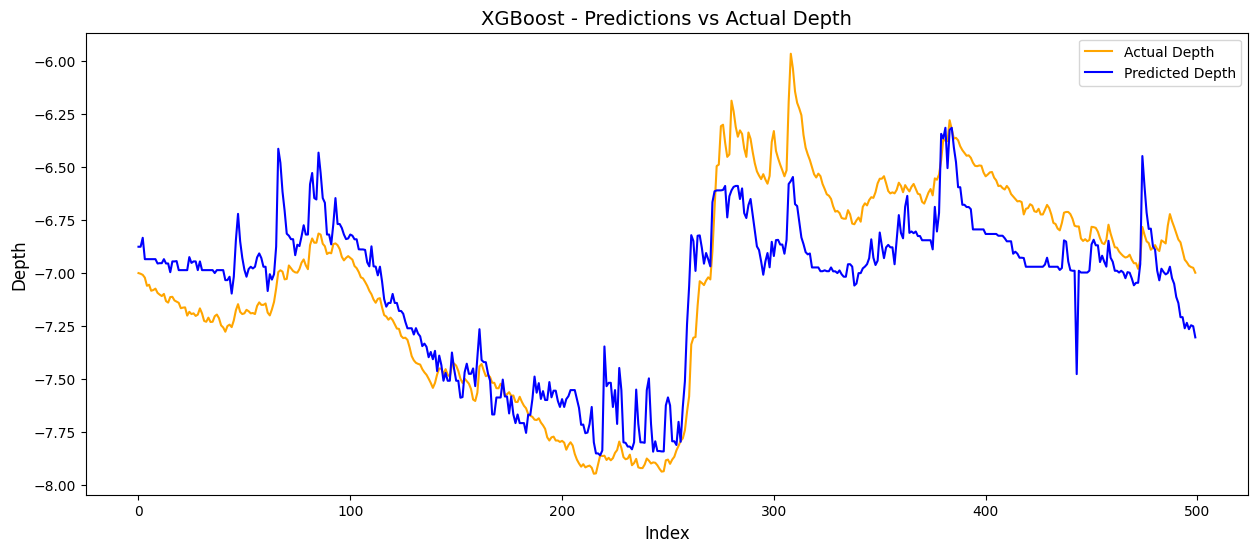

In [29]:
# Assuming y_pred contains predictions from the XGBoost model and y_valid contains the actual values
# Plot the predictions versus actual values
plt.figure(figsize=(15, 6))

# Plot actual values
plt.plot(y_valid.reset_index(drop=True), label='Actual Depth', color='orange')

# Plot predicted values
plt.plot(y_pred, label='Predicted Depth', color='blue')

plt.title('XGBoost - Predictions vs Actual Depth', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Depth', fontsize=12)
plt.legend()
plt.show()


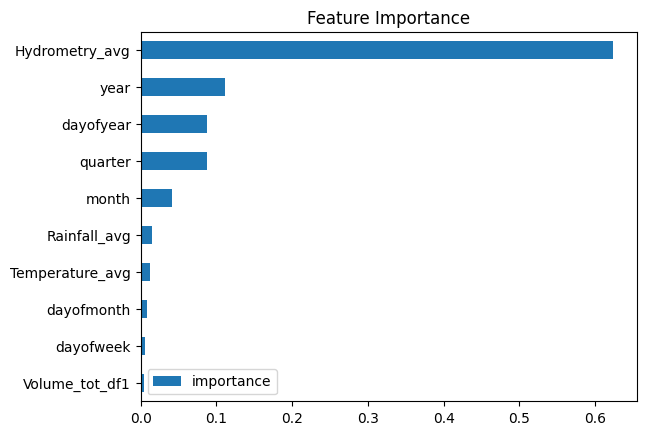

In [30]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## 6. Conclusion | Summary of Results

LSTM model yielded the lowest RMSE at 0.0281. Second was the XGBoost.

In [31]:
data = [
    {"Model": "Univ-LSTM", "MAE": 0.0281, "RMSE": 0.0479},
    {"Model": "Muilti-XGBoost", "MAE": 0.2027, "RMSE": 0.2352},
    {"Model": "Multi-Prophet", "MAE": 0.2228, "RMSE": 0.2718},
    {"Model": "Univ-Prophet", "MAE": 0.2328, "RMSE": 0.3175},
    {"Model": "Univ-ARIMA", "MAE": 0.3914, "RMSE": 0.4758}]
  
# Creating the DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df.head()

,Model,MAE,RMSE
0,Univ-LSTM,0.03,0.05
1,Muilti-XGBoost,0.20,0.24
2,Multi-Prophet,0.22,0.27
3,Univ-Prophet,0.23,0.32
4,Univ-ARIMA,0.39,0.48


# References

* Special reference for the helpful information and plots - https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting
* ARIMA - https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06
* Auto-ARIMA - https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
* Keras LSTM - https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* Prophet - https://towardsdatascience.com/time-series-prediction-using-prophet-in-python-35d65f626236
* Special reference - https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting/notebook#Models
* Cyclical features - https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca
* ADF - https://medium.com/@cmukesh8688/why-is-augmented-dickey-fuller-test-adf-test-so-important-in-time-series-analysis-6fc97c6be2f0
* ACF/PACF - https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8
* LSTM - https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba